# Introduction  


In other notebooks we reviewed the information about distribution of Kaggle Grandmasters, based on combination of Meta Kaggle dataset and the Meta Kagle Master Achievements Snapshot dataset. One of the information included with the latest dataset is the Kaggle tenure (in years) of each user and the last time when the user was online.     
In this notebook we will mine the information in this field to extract the tenure and the last time the user was active on the platform.



In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
achievements_df = pd.read_csv("/kaggle/input/meta-kagglemaster-achievements-snapshot/MasterAchievements.csv")

In [3]:
profiles_df = pd.read_csv("/kaggle/input/meta-kagglemaster-achievements-snapshot/MasterProfiles.csv")

In [4]:
achievements_df.head()

,UserName,Competitions,Datasets,Notebooks,Discussion,HighestRank,snapshot_date
0,jmeynet,master,contributor,contributor,contributor,85,2023-09-23
1,dremovd,master,contributor,expert,expert,53,2023-09-23
2,quansun,master,contributor,contributor,contributor,6,2023-09-23
3,teamben,master,contributor,contributor,contributor,90,2023-09-23
4,alexxanderlarko,grandmaster,contributor,expert,expert,3,2023-09-23


In [5]:
profiles_df.head()

,UserName,Avatar,Location,Metadata,snapshot_date,Latitude,Longitude,GeoLocation,Country
0,jmeynet,https://storage.googleapis.com/kaggle-avatars/...,"Barcelona, Catalonia, Spain",Joined 14 years ago · last seen 3 years ago,2023-09-23,41.382894,2.177432,"Barcelona, Barcelonès, Barcelona, Catalonia, 0...",Spain
1,dremovd,https://storage.googleapis.com/kaggle-avatars/...,"Pattaya City, Chon Buri, Thailand",Joined 14 years ago · last seen 2 months ago,2023-09-23,12.924254,100.865587,"Pattaya City Public Park, Pattaya, Na Chom Thi...",Thailand
2,quansun,https://storage.googleapis.com/kaggle-avatars/...,New Zealand,Joined 13 years ago · last seen 7 months ago,2023-09-23,-41.500083,172.834408,New Zealand,New Zealand
3,teamben,https://storage.googleapis.com/kaggle-avatars/...,"Melbourne, Victoria, Australia",Joined 13 years ago · last seen 7 years ago,2023-09-23,-37.814245,144.963173,"Melbourne, City of Melbourne, Victoria, Australia",Australia
4,alexxanderlarko,https://storage.googleapis.com/kaggle-avatars/...,"Minusinsk, Krasnoyarsk Krai, Russia",Joined 13 years ago · last seen in the past day,2023-09-23,53.700325,91.697235,"Minusinsk, Красноярский кадастровый район, Kra...",Russia


In [6]:
print(profiles_df.shape, achievements_df.shape)

(2904, 9) (2904, 7)


# Data processing


We separate first the tenure and the last seen component.  
Then we extract and normalize the tenure time and last active time.  
To complete our data processing, we normalize the tenure to months and the last seen to days.

In [7]:
profiles_df["joined"] = profiles_df["Metadata"].apply(lambda x: x.split(" · ")[0])
profiles_df["last_seen"] = profiles_df["Metadata"].apply(lambda x: x.split(" · ")[1])

Let's inspect the `joined` and `last_seen` fields.

In [8]:
print("Joined values: ", profiles_df["joined"].nunique())
profiles_df["joined"].value_counts()

Joined values:  20


joined
Joined 6 years ago      390
Joined 5 years ago      301
Joined 7 years ago      267
Joined 8 years ago      255
Joined 11 years ago     254
Joined 9 years ago      248
Joined 4 years ago      246
Joined 3 years ago      223
Joined 10 years ago     221
Joined 12 years ago     181
Joined 2 years ago      149
Joined 13 years ago      99
Joined a year ago        49
Joined 7 months ago       5
Joined 9 months ago       5
Joined 10 months ago      3
Joined 8 months ago       3
Joined 14 years ago       2
Joined 5 months ago       2
Joined 6 months ago       1
Name: count, dtype: int64

In [9]:
print("Last seen values: ", profiles_df["last_seen"].nunique())
profiles_df["last_seen"].value_counts()

Last seen values:  48


last_seen
last seen in the past day    724
last seen a year ago         196
last seen a month ago        165
last seen 2 months ago       152
last seen 2 years ago        133
last seen 2 days ago         124
last seen 3 months ago       101
last seen 4 months ago        93
last seen 3 years ago         79
last seen a day ago           75
last seen 3 days ago          73
last seen 6 months ago        70
last seen 7 months ago        67
last seen 5 months ago        67
last seen 4 years ago         55
last seen 4 days ago          44
last seen 8 months ago        43
last seen 9 months ago        42
last seen 10 months ago       39
last seen 5 years ago         38
last seen 6 years ago         37
last seen 5 days ago          32
last seen 7 days ago          31
last seen 9 days ago          30
last seen 7 years ago         29
last seen 8 days ago          27
last seen 6 days ago          25
last seen 11 days ago         23
last seen 24 days ago         22
last seen 10 days ago         20


In [10]:
def extract_tenure(joined):
    """
    Extract and return tenure in months
    Args:
        joined: the text giving the tenure
    Returns:
        tenure in month
    """
    multiplier = 1
    joined = re.sub("Joined ", "", joined)
    joined = re.sub(" ago", "", joined)
    quantity, metric = joined.split(" ")
    if quantity == "a":
        quantity = 1
    else:
        quantity = int(quantity)
    if metric == "year" or metric == "years":
        multiplier = 12

    return quantity * multiplier

In [11]:
def extract_last_seen(last_seen):
    """
    Extract and return when user was last time seen
    Args:
        last_seen: the text showing when user was last time seen
    Returns:
        number of days from when the user was last time seen
    """
    multiplier = 1
    last_seen = re.sub("last seen ", "", last_seen)
    if last_seen == "in the past day":
        return 0
    last_seen = re.sub(" ago", "", last_seen)
    quantity, metric = last_seen.split(" ")
    if quantity == "a":
        quantity = 1
    else:
        quantity = int(quantity)
    if metric == "year" or metric == "years":
        multiplier = 356
    elif metric == "month" or metric == "months":
        multiplier = 30
    
    return quantity * multiplier

In [12]:
profiles_df["tenure"] = profiles_df["joined"].apply(lambda x: extract_tenure(x))
profiles_df["last_seen_days"] = profiles_df["last_seen"].apply(lambda x: extract_last_seen(x))

# Data exploration

Let's merge achievements with profiles datasets.

In [13]:
user_df = profiles_df.merge(achievements_df)

In [14]:
user_df.head()

,UserName,Avatar,Location,Metadata,snapshot_date,Latitude,Longitude,GeoLocation,Country,joined,last_seen,tenure,last_seen_days,Competitions,Datasets,Notebooks,Discussion,HighestRank
0,jmeynet,https://storage.googleapis.com/kaggle-avatars/...,"Barcelona, Catalonia, Spain",Joined 14 years ago · last seen 3 years ago,2023-09-23,41.382894,2.177432,"Barcelona, Barcelonès, Barcelona, Catalonia, 0...",Spain,Joined 14 years ago,last seen 3 years ago,168,1068,master,contributor,contributor,contributor,85
1,dremovd,https://storage.googleapis.com/kaggle-avatars/...,"Pattaya City, Chon Buri, Thailand",Joined 14 years ago · last seen 2 months ago,2023-09-23,12.924254,100.865587,"Pattaya City Public Park, Pattaya, Na Chom Thi...",Thailand,Joined 14 years ago,last seen 2 months ago,168,60,master,contributor,expert,expert,53
2,quansun,https://storage.googleapis.com/kaggle-avatars/...,New Zealand,Joined 13 years ago · last seen 7 months ago,2023-09-23,-41.500083,172.834408,New Zealand,New Zealand,Joined 13 years ago,last seen 7 months ago,156,210,master,contributor,contributor,contributor,6
3,teamben,https://storage.googleapis.com/kaggle-avatars/...,"Melbourne, Victoria, Australia",Joined 13 years ago · last seen 7 years ago,2023-09-23,-37.814245,144.963173,"Melbourne, City of Melbourne, Victoria, Australia",Australia,Joined 13 years ago,last seen 7 years ago,156,2492,master,contributor,contributor,contributor,90
4,alexxanderlarko,https://storage.googleapis.com/kaggle-avatars/...,"Minusinsk, Krasnoyarsk Krai, Russia",Joined 13 years ago · last seen in the past day,2023-09-23,53.700325,91.697235,"Minusinsk, Красноярский кадастровый район, Kra...",Russia,Joined 13 years ago,last seen in the past day,156,0,grandmaster,contributor,expert,expert,3


Let's look first to the distribution of tenure and number of days since last seen, separately.

In [15]:
def plot_distribution_pairs(data_df, feature, title, xlabel, hue="Competitions"):
    f, ax = plt.subplots(1, 1, figsize=(8, 4))
    for i, h in enumerate(data_df[hue].unique()):
        g = sns.histplot(data_df.loc[data_df[hue]==h, feature],
                         ax=ax, label=h)
    ax.set_title(f"Users distribution by {title}")
    #ax.set_yscale('log')
    #ax.set_xscale('log')
    ax.set_xlabel(xlabel)
    g.legend()
    plt.show() 

In [16]:
user_df.columns

Index(['UserName', 'Avatar', 'Location', 'Metadata', 'snapshot_date',
       'Latitude', 'Longitude', 'GeoLocation', 'Country', 'joined',
       'last_seen', 'tenure', 'last_seen_days', 'Competitions', 'Datasets',
       'Notebooks', 'Discussion', 'HighestRank'],
      dtype='object')

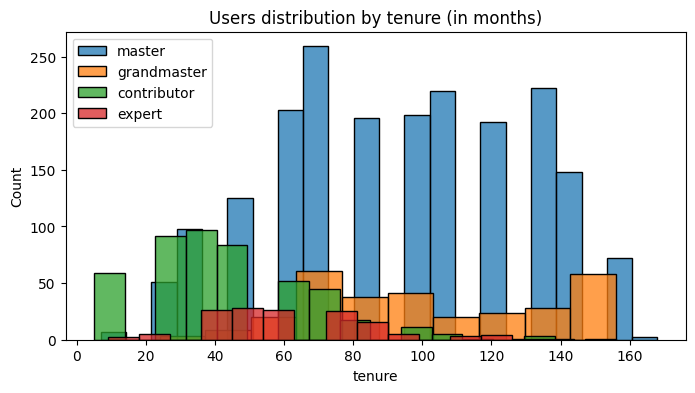

In [17]:
plot_distribution_pairs(user_df, "tenure", "tenure (in months)", "tenure")

In [18]:
gm_user_all_df = user_df.loc[user_df.Notebooks.isin(["master", "grandmaster"])]

In [19]:
gm_user_df = user_df.loc[user_df.Notebooks.isin(["master", "grandmaster"]) & (user_df.last_seen_days < 181)]

In [20]:
gm_user_all_df.shape, gm_user_df.shape

((619, 18), (578, 18))

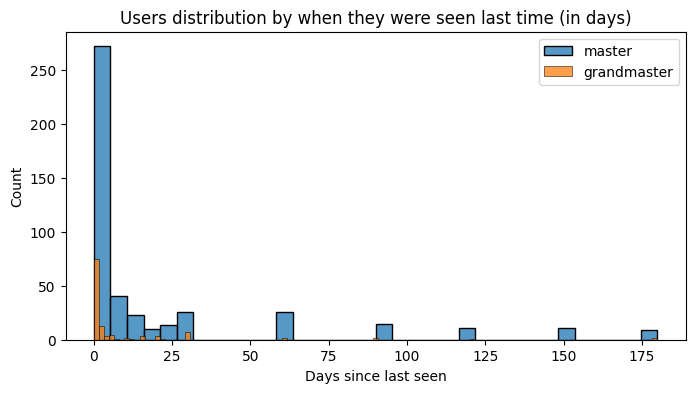

In [21]:
plot_distribution_pairs(gm_user_df, "last_seen_days", "when they were seen last time (in days)", "Days since last seen", hue="Notebooks")

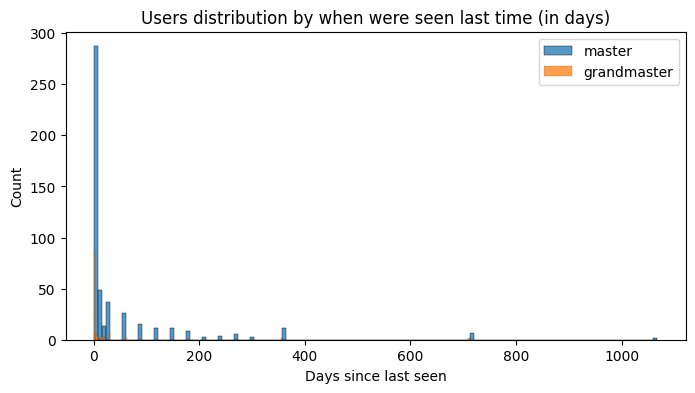

In [22]:
plot_distribution_pairs(gm_user_all_df, "last_seen_days", "when were seen last time (in days)", "Days since last seen", hue="Notebooks")